In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

In [2]:
import statsmodels.api as sm 
import itertools
from scipy import stats
sns.set()
#%pylab inline

In [3]:
for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.14.2
pandas 0.23.4
sklearn 0.19.1
scipy 0.19.1
lightgbm 2.1.1
seaborn 0.8.0


In [4]:
import gc
from tqdm import tqdm_notebook
def downcast_dtypes(df):
    '''
    Changes column types in the dataframe: 

        `float64` type to `float32`
        `int64`   type to `int32`
    '''

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    object_cols =   [c for c in df if df[c].dtype == "object"]
    # Downcast
    for i in float_cols:
        df[i] = df[i].astype(np.float32)
    for j in int_cols  : 
        df[j]   = df[j].astype(np.int32)
    for j in object_cols  : 
        df[j]   = df[j].astype(str).astype(int)

    return df


def rmse(*args):
    
    """ Funcion that calculates the root mean squared error"""
    return np.sqrt(mean_squared_error(*args))


def clip20(x):
    return np.clip(x, 0, 20)

def clip40(x):
    return np.clip(x, 0, 20)


# Hyper_tuning

* light_gbm

In [5]:
from math import sqrt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lgb
seed=1204


In [6]:
cv_loss_list=[]
n_iteration_list=[]
def score(params,):
    print("Training with params: ")
    print(params)
    cv_losses=[]
    cv_iteration=[]
    for (train_idx,val_idx) in cv:
        cv_train = X.iloc[train_idx]
        cv_val = X.iloc[val_idx]
        cv_y_train = y[train_idx]
        cv_y_val = y[val_idx]
        lgb_model = lgb.train(params, lgb.Dataset(cv_train, label=cv_y_train), 2000, 
                          lgb.Dataset(cv_val, label=cv_y_val), verbose_eval=False, 
                          early_stopping_rounds=100)
       
        train_pred = lgb_model.predict(cv_train,lgb_model.best_iteration+1)
        val_pred = lgb_model.predict(cv_val,lgb_model.best_iteration+1)
        
        val_loss = root_mean_squared_error(cv_y_val,val_pred)
        train_loss = root_mean_squared_error(cv_y_train,train_pred)
        print('Train RMSE: {}. Val RMSE: {}'.format(train_loss,val_loss))
        print('Best iteration: {}'.format(lgb_model.best_iteration))
        cv_losses.append(val_loss)
        cv_iteration.append(lgb_model.best_iteration)
    print('6 fold results: {}'.format(cv_losses))
    cv_loss_list.append(cv_losses)
    n_iteration_list.append(cv_iteration)
    
    mean_cv_loss = np.mean(cv_losses)
    print('Average iterations: {}'.format(np.mean(cv_iteration)))
    print("Mean Cross Validation RMSE: {}\n".format(mean_cv_loss))
    return {'loss': mean_cv_loss, 'status': STATUS_OK}

def optimize(space,seed=seed,max_evals=5):
    
    best = fmin(score, space, algo=tpe.suggest, 
        # trials=trials, 
        max_evals=max_evals)
    return best
def get_cv_idxs(df,start,end):
    result=[]
    for i in range(start,end+1):
        dates = df.date_block_num
        train_idx = np.array(df.loc[dates <i].index)
        val_idx = np.array(df.loc[dates == i].index)
        result.append((train_idx,val_idx))
    return np.array(result)
def get_X_y(df,end,clip=20):
    # don't drop date_block_num
    df = df.loc[df.date_block_num <= end]
    cols_to_drop=to_drop_cols
    y = np.clip(df.target.values,0,clip)
    X = df.drop(cols_to_drop,axis=1)
    return X,y
def get_all_data(data_path,filename):
    all_data = pd.read_pickle(data_path + filename)
    #all_data = downcast_dtypes(all_data)
    all_data = all_data.reset_index().drop('index',axis=1)
    return all_data
def root_mean_squared_error(truth,pred):
    return sqrt(mean_squared_error(truth,pred))

In [7]:
all_data = get_all_data("journey/data/",'new_train.pickle')

In [8]:
to_drop_cols=['item__target_mean',"item_id",
 'shop__target_mean','item_category_id',#"shop_id",
 'item_mean','is_holiday','is_business_day','is_weekend',
 'target_mean',"item_time",
 'target',#"city_code",
 'date_block_num','year_min',#"month_min" 
 'item_cnt_day_year_shop_id', 
  #'date_block_num_min',
 'item_cnt_day_mean_new', 'item_cnt_day_shop_id',
 'item_cnt_day_year_shop_id', 'item_cnt_day_cats_id',
'item_cnt_day_year_cats_id','item_cnt_day_new_shop','item_cnt_day_new_cats',
             'item_mean_lag_3','item_mean_lag_2','item_mean_lag_1','item_mean_lag_6','item_mean_lag_12']

In [9]:
to_drop_cols=['item__target_mean',"item_id",
 'shop__target_mean','item_category_id',"shop_id",
 'item_mean','is_holiday','is_business_day','is_weekend',
 'target_mean',
 'target',#"city_code",
 'date_block_num','year_min',"month_min",
 'item_cnt_day_year_shop_id', 
  #'date_block_num_min',
 'item_cnt_day_mean_new', 'item_cnt_day_shop_id',
 'item_cnt_day_year_shop_id', 'item_cnt_day_cats_id',
'item_cnt_day_year_cats_id','item_cnt_day_new_shop','item_cnt_day_new_cats']

In [10]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_mean',
       'shop__target_mean', 'item_category_id', 'item__target_mean',
       'item_mean', 'item__target_mean_lag_1', 'item_mean_lag_1',
       'shop__target_mean_lag_1', 'target_lag_1', 'target_mean_lag_1',
       'item__target_mean_lag_2', 'item_mean_lag_2', 'shop__target_mean_lag_2',
       'target_lag_2', 'target_mean_lag_2', 'item__target_mean_lag_3',
       'item_mean_lag_3', 'shop__target_mean_lag_3', 'target_lag_3',
       'target_mean_lag_3', 'item__target_mean_lag_6', 'item_mean_lag_6',
       'shop__target_mean_lag_6', 'target_lag_6', 'target_mean_lag_6',
       'item__target_mean_lag_12', 'item_mean_lag_12',
       'shop__target_mean_lag_12', 'target_lag_12', 'target_mean_lag_12',
       'city_code', 'new_cats', 'year_min', 'month_min',
       'item_cnt_day_mean_new', 'item_cnt_day_shop_id',
       'item_cnt_day_year_shop_id', 'item_cnt_day_cats_id',
       'item_cnt_day_year_cats_id', 'item_cnt_day_new_s

In [11]:
X,y = get_X_y(all_data,33)

#X.drop('date_block_num',axis=1,inplace=True)

cv = get_cv_idxs(all_data,28,33)

In [12]:
X.columns

Index(['item__target_mean_lag_1', 'item_mean_lag_1', 'shop__target_mean_lag_1',
       'target_lag_1', 'target_mean_lag_1', 'item__target_mean_lag_2',
       'item_mean_lag_2', 'shop__target_mean_lag_2', 'target_lag_2',
       'target_mean_lag_2', 'item__target_mean_lag_3', 'item_mean_lag_3',
       'shop__target_mean_lag_3', 'target_lag_3', 'target_mean_lag_3',
       'item__target_mean_lag_6', 'item_mean_lag_6', 'shop__target_mean_lag_6',
       'target_lag_6', 'target_mean_lag_6', 'item__target_mean_lag_12',
       'item_mean_lag_12', 'shop__target_mean_lag_12', 'target_lag_12',
       'target_mean_lag_12', 'city_code', 'new_cats', 'date_block_num_min',
       'item_cnt_day_date_shop', 'item_cnt_day_date_cats', 'month'],
      dtype='object')

In [24]:
space ={#'max_depth': hp.choice('max_depth', np.arange(14, 50, dtype=int)),
    'subsample': hp.quniform('subsample', 0.55, 0.8, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.55, 0.8, 0.05),
    'min_data_in_leaf': hp.choice('min_data_in_leaf',np.arange(80, 220,1, dtype=int)),
    'learning_rate': hp.quniform('learning_rate', 0.03, 0.1, 0.01),
    'seed':seed,
    'objective': 'regression',
    'metric':'rmse',
       }
    

best_hyperparams = optimize(space,max_evals=200)
print("The best hyperparameters are: ")
print(best_hyperparams)

Training with params: 
{'colsample_bytree': 0.55, 'learning_rate': 0.04, 'metric': 'rmse', 'min_data_in_leaf': 141, 'objective': 'regression', 'seed': 1204, 'subsample': 0.65}
Train RMSE: 0.7862057346351805. Val RMSE: 0.7586162329829124
Best iteration: 607
Train RMSE: 0.8334506316677729. Val RMSE: 0.7240308874633675
Best iteration: 118
Train RMSE: 0.8057173401979066. Val RMSE: 0.6671599009902035
Best iteration: 247
Train RMSE: 0.740611524758117. Val RMSE: 0.7139184095563955
Best iteration: 1791
Train RMSE: 0.7638056672188214. Val RMSE: 0.8075047923266642
Best iteration: 760
Train RMSE: 0.7723905810088001. Val RMSE: 0.8497138142868826
Best iteration: 594
6 fold results: [0.7586162329829124, 0.7240308874633675, 0.6671599009902035, 0.7139184095563955, 0.8075047923266642, 0.8497138142868826]
Average iterations: 686.1666666666666
Mean Cross Validation RMSE: 0.7534906729344043

Training with params: 
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.03, 'metric': 'rmse', 'min_data_

KeyboardInterrupt: 

Training with params: 
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.03, 'metric': 'rmse', 'min_data_in_leaf': 90, 'objective': 'regression', 'seed': 1204, 'subsample': 0.75}
Train RMSE: 0.804508668076558. Val RMSE: 0.7515904669240216
Best iteration: 378
Train RMSE: 0.8375121520823315. Val RMSE: 0.7256121342327126
Best iteration: 129
Train RMSE: 0.7911283441679476. Val RMSE: 0.6657933585250229
Best iteration: 474
Train RMSE: 0.7414998605976901. Val RMSE: 0.7166950337922008
Best iteration: 1936
Train RMSE: 0.7764860584814761. Val RMSE: 0.8100359242759037
Best iteration: 593
Train RMSE: 0.7715194616301064. Val RMSE: 0.8498722050858607
Best iteration: 722
6 fold results: [0.7515904669240216, 0.7256121342327126, 0.6657933585250229, 0.7166950337922008, 0.8100359242759037, 0.8498722050858607]
Average iterations: 705.3333333333334
Mean Cross Validation RMSE: 0.7532665204726204


{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'metric': 'rmse', 'min_data_in_leaf': 102, 'objective': 'regression', 'seed': 1204, 'subsample': 0.8}
Train RMSE: 0.8038509125607478. Val RMSE: 0.7551853345082391
Best iteration: 129
Train RMSE: 0.8292975805905733. Val RMSE: 0.7244777822445266
Best iteration: 55
Train RMSE: 0.792478592560271. Val RMSE: 0.667693245535393
Best iteration: 152
Train RMSE: 0.7346716168748313. Val RMSE: 0.7167504653857543
Best iteration: 778
Train RMSE: 0.7511654367069859. Val RMSE: 0.8026302791012923
Best iteration: 439
Train RMSE: 0.7742918529182516. Val RMSE: 0.8521335148588837
Best iteration: 213
6 fold results: [0.7551853345082391, 0.7244777822445266, 0.667693245535393, 0.7167504653857543, 0.8026302791012923, 0.8521335148588837]
Average iterations: 294.3333333333333
Mean Cross Validation RMSE: 0.7531451036056814




--------------------------------------------------------------------------------------------------------------------------------
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'metric': 'rmse', 'min_data_in_leaf': 97, 'objective': 'regression', 'seed': 1204, 'subsample': 0.8500000000000001}
Train RMSE: 0.8008883307994588. Val RMSE: 0.7510025597649588
Best iteration: 515
Train RMSE: 0.8363487982792545. Val RMSE: 0.7257268077834884
Best iteration: 154
Train RMSE: 0.7650077698833878. Val RMSE: 0.6643278509846962
Best iteration: 1291
Train RMSE: 0.7588960722070511. Val RMSE: 0.7174214001876109
Best iteration: 1338
Train RMSE: 0.7671198464463626. Val RMSE: 0.807918945685582
Best iteration: 959
Train RMSE: 0.7752694494738779. Val RMSE: 0.8538415465708752
Best iteration: 755
6 fold results: [0.7510025597649588, 0.7257268077834884, 0.6643278509846962, 0.7174214001876109, 0.807918945685582, 0.8538415465708752]
Average iterations: 835.3333333333334
Mean Cross Validation RMSE: 0.7533731851628686


--------------------------------------------------------------------------------------------------------------------------------
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'metric': 'rmse', 'min_data_in_leaf': 53, 'objective': 'regression', 'seed': 1204, 'subsample': 0.75}
Train RMSE: 0.7914450702559286. Val RMSE: 0.7552625009569927
Best iteration: 138
Train RMSE: 0.8168394564350862. Val RMSE: 0.7215109871420411
Best iteration: 61
Train RMSE: 0.7669243082148185. Val RMSE: 0.6655420606495884
Best iteration: 242
Train RMSE: 0.7359763767805778. Val RMSE: 0.7210934515518056
Best iteration: 566
Train RMSE: 0.7675470201623453. Val RMSE: 0.807540309441726
Best iteration: 194
Train RMSE: 0.7687335132517438. Val RMSE: 0.8523494423994802
Best iteration: 194
6 fold results: [0.7552625009569927, 0.7215109871420411, 0.6655420606495884, 0.7210934515518056, 0.807540309441726, 0.8523494423994802]
Average iterations: 232.5
Mean Cross Validation RMSE: 0.753883125356939
--------------------------------------------------------------------------------------------------------------------------------
Training with params: 
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'metric': 'rmse', 'min_data_in_leaf': 124, 'objective': 'regression', 'seed': 1204, 'subsample': 0.8500000000000001}
Train RMSE: 0.7627641526136165. Val RMSE: 0.7522923923568563
Best iteration: 1239
Train RMSE: 0.8294852632958439. Val RMSE: 0.72196891371843
Best iteration: 130
Train RMSE: 0.8221030656881498. Val RMSE: 0.6686749714162613
Best iteration: 140
Train RMSE: 0.7478081164762248. Val RMSE: 0.7151347225490458
Best iteration: 1438
Train RMSE: 0.7994797263511096. Val RMSE: 0.8143777649017565
Best iteration: 220
Train RMSE: 0.780575974081469. Val RMSE: 0.8483699523175424
Best iteration: 438
6 fold results: [0.7522923923568563, 0.72196891371843, 0.6686749714162613, 0.7151347225490458, 0.8143777649017565, 0.8483699523175424]
Average iterations: 600.8333333333334
Mean Cross Validation RMSE: 0.753469786209982





-----------------------------------------------------------------------------------------------------------------------------
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'metric': 'rmse', 'min_data_in_leaf': 196, 'objective': 'regression', 'seed': 1204, 'subsample': 0.6000000000000001}
Train RMSE: 0.7684758826222334. Val RMSE: 0.753443995485394
Best iteration: 560
Train RMSE: 0.8391963720244254. Val RMSE: 0.7259806725971716
Best iteration: 53
Train RMSE: 0.7959735258285534. Val RMSE: 0.6668561711859601
Best iteration: 180
Train RMSE: 0.7612059154886548. Val RMSE: 0.7203958076619819
Best iteration: 479
Train RMSE: 0.7801671186166244. Val RMSE: 0.8078238574661616
Best iteration: 239
Train RMSE: 0.7761710712948411. Val RMSE: 0.8544337151578789
Best iteration: 292
6 fold results: [0.753443995485394, 0.7259806725971716, 0.6668561711859601, 0.7203958076619819, 0.8078238574661616, 0.8544337151578789]
Average iterations: 300.5
Mean Cross Validation RMSE: 0.754822369925758

In [28]:
lgb_params ={'colsample_bytree': 0.75, 'learning_rate': 0.05, 'metric': 'rmse', 'min_data_in_leaf': 160, 'objective': 'regression', 'seed': 1204, 'subsample': 0.8500000000000001}

In [20]:
lgb_params={'colsample_bytree': 0.75, 'learning_rate': 0.05, 'metric': 'rmse', 'min_data_in_leaf': 219, 'objective': 'regression', 'seed': 1204, 'subsample': 0.6000000000000001}

In [44]:
lgb_params={'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'metric': 'rmse', 'min_data_in_leaf': 102, 'objective': 'regression', 'seed': 1204, 'subsample': 0.8}

In [36]:
test3=pd.read_csv("lgb_new5.csv")

test3=test3.item_cnt_month

In [37]:
test = pd.read_pickle("journey/data/sub_data.pickle")

test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_cats_id"]=test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_year_cats_id"]

test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_shop_id"]=test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_year_shop_id"]

X_test=test.drop(to_drop_cols,axis=1)

In [45]:
%%time


lgb_model_full = lgb.train(lgb_params, lgb.Dataset(X, label=y), 484, 
                      lgb.Dataset(X_test, label=test3), verbose_eval=10)

[10]	valid_0's rmse: 0.496617
[20]	valid_0's rmse: 0.362157
[30]	valid_0's rmse: 0.303668
[40]	valid_0's rmse: 0.281571
[50]	valid_0's rmse: 0.268038
[60]	valid_0's rmse: 0.261484
[70]	valid_0's rmse: 0.254616
[80]	valid_0's rmse: 0.248164
[90]	valid_0's rmse: 0.243423
[100]	valid_0's rmse: 0.231943
[110]	valid_0's rmse: 0.230728
[120]	valid_0's rmse: 0.229061
[130]	valid_0's rmse: 0.229262
[140]	valid_0's rmse: 0.227569
[150]	valid_0's rmse: 0.226121
[160]	valid_0's rmse: 0.222849
[170]	valid_0's rmse: 0.221772
[180]	valid_0's rmse: 0.221704
[190]	valid_0's rmse: 0.220988
[200]	valid_0's rmse: 0.221139
[210]	valid_0's rmse: 0.218854
[220]	valid_0's rmse: 0.218608
[230]	valid_0's rmse: 0.217751
[240]	valid_0's rmse: 0.217399
[250]	valid_0's rmse: 0.218368
[260]	valid_0's rmse: 0.219477
[270]	valid_0's rmse: 0.219851
[280]	valid_0's rmse: 0.219856
[290]	valid_0's rmse: 0.219603
[300]	valid_0's rmse: 0.219647
[310]	valid_0's rmse: 0.219827
[320]	valid_0's rmse: 0.219992
[330]	valid_0's r

In [46]:
for (train_idx,val_idx) in cv:
    X_val = X.iloc[val_idx]
    y_val = y[val_idx]

pred_lgb_val = lgb_model_full.predict(X_val)
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Val RMSE for lgb is 0.792970


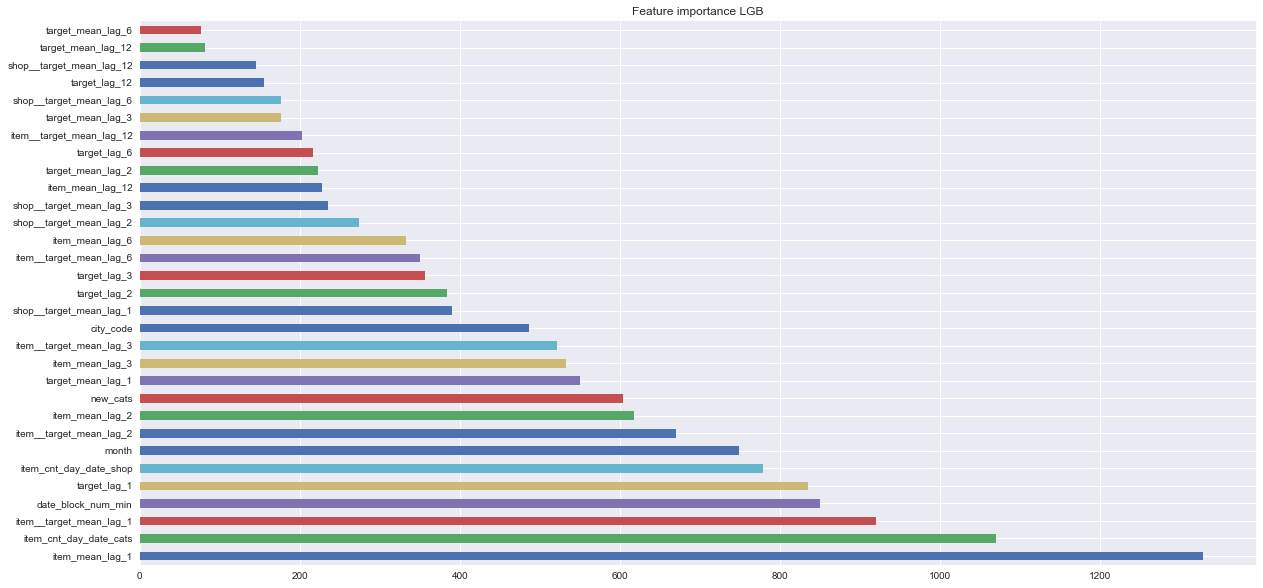

In [47]:
feat_importances = pd.Series(lgb_model_full.feature_importance(), index=X.columns)
feat_importances = feat_importances.nlargest(70)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

In [41]:
test4=pd.read_csv("lgb_new1.csv")

test4=test4.item_cnt_month

FileNotFoundError: File b'lgb_new1.csv' does not exist

In [59]:
test = pd.read_pickle("journey/data/sub_data.pickle")
test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_cats_id"]=test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_year_cats_id"]
test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_shop_id"]=test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_year_shop_id"]
test.loc[test['year_min'] == 2013, 'item_time'] = 36
test.loc[test['year_min'] == 2014, 'item_time'] = 24
test.loc[test['year_min'] == 2015, 'item_time'] = 12
l=test.item_time-test.month_min
test["item_time"]=l
test.drop(to_drop_cols,axis=1,inplace=True)
test_pred_lgb = lgb_model_full.predict(test)

In [60]:
print('Val RMSE for lgb is %f' % rmse(clip20(test4), clip20(test_pred_lgb)))

Val RMSE for lgb is 0.216894


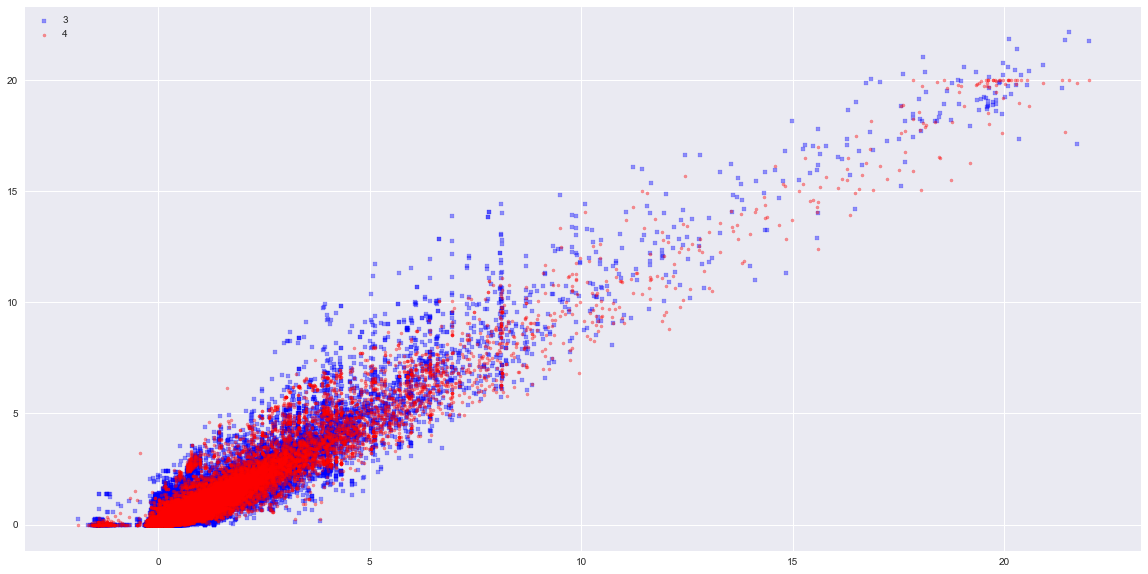

In [61]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(test_pred_lgb,test3, s=10, c='b', marker="s", label='3',alpha=0.4)
ax1.scatter(test_pred_lgb,test4, s=10, c='r', marker="o", label='4',alpha=0.4)
plt.legend(loc='upper left');
plt.show()



# Permutation Importance

In [316]:
to_drop_cols=['item__target_mean',
 'shop__target_mean',
 'item_mean', 
 'target_mean',
 'target',
 'date_block_num','year_min', 
 'item_cnt_day_year_shop_id', 
 "month_min", 
 'item_cnt_day_mean_new', 'item_cnt_day_shop_id',
 'item_cnt_day_year_shop_id', 'item_cnt_day_cats_id',
'item_cnt_day_year_cats_id', 'month', 'is_weekend', 'is_business_day','is_holiday',
 'item_mean_lag_1','item_mean_lag_2','item_mean_lag_3','item_mean_lag_6','item_mean_lag_12']
X,y = get_X_y(all_data,33)
cv = get_cv_idxs(all_data,28,33)
for (train_idx,val_idx) in cv:
    X_val = X.iloc[val_idx]
    y_val = y[val_idx]

In [315]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_mean',
       'shop__target_mean', 'item_category_id', 'item__target_mean',
       'item_mean', 'item__target_mean_lag_1', 'item_mean_lag_1',
       'shop__target_mean_lag_1', 'target_lag_1', 'target_mean_lag_1',
       'item__target_mean_lag_2', 'item_mean_lag_2', 'shop__target_mean_lag_2',
       'target_lag_2', 'target_mean_lag_2', 'item__target_mean_lag_3',
       'item_mean_lag_3', 'shop__target_mean_lag_3', 'target_lag_3',
       'target_mean_lag_3', 'item__target_mean_lag_6', 'item_mean_lag_6',
       'shop__target_mean_lag_6', 'target_lag_6', 'target_mean_lag_6',
       'item__target_mean_lag_12', 'item_mean_lag_12',
       'shop__target_mean_lag_12', 'target_lag_12', 'target_mean_lag_12',
       'city_code', 'new_cats', 'year_min', 'month_min',
       'item_cnt_day_mean_new', 'item_cnt_day_shop_id',
       'item_cnt_day_year_shop_id', 'item_cnt_day_cats_id',
       'item_cnt_day_year_cats_id', 'item_cnt_day_new_s

In [317]:
%%time
lgb_params={'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'metric': 'rmse', 'min_data_in_leaf': 102, 'objective': 'regression', 'seed': 1204, 'subsample': 0.65}
gbm = lgb.LGBMRegressor(colsample_bytree= 0.7000000000000001,learning_rate= 0.14,min_data_in_leaf= 202,seed= 1204, subsample= 0.65,objective='regression')
my_model = gbm.fit(X,y,eval_set=(X_val, y_val),eval_metric="l2_root",verbose=10)

[10]	valid_0's rmse: 0.88475
[20]	valid_0's rmse: 0.866259
[30]	valid_0's rmse: 0.859281
[40]	valid_0's rmse: 0.849825
[50]	valid_0's rmse: 0.841886
[60]	valid_0's rmse: 0.830687
[70]	valid_0's rmse: 0.819629
[80]	valid_0's rmse: 0.81471
[90]	valid_0's rmse: 0.808712
[100]	valid_0's rmse: 0.801569
Wall time: 42.7 s


In [318]:
pred_lgb_val = my_model.predict(X_val)
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Val RMSE for lgb is 0.801220


In [319]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist(),top=40)

Weight,Feature
0.2022 ± 0.0018,target_lag_1
0.0743 ± 0.0042,date_block_num_min
0.0598 ± 0.0027,item_cnt_day_date_cats
0.0579 ± 0.0025,item_cnt_day_date_shop
0.0567 ± 0.0020,item_cnt_day_new_shop
0.0515 ± 0.0037,item_id
0.0506 ± 0.0023,item_time
0.0456 ± 0.0020,item_category_id
0.0300 ± 0.0017,item__target_mean_lag_1
0.0249 ± 0.0007,target_lag_2


# SHAP Values

In [298]:
X_val.iloc[row_to_show]

shop_id                        45.000000
item_id                     14931.000000
item_category_id               69.000000
item__target_mean_lag_1         1.021505
shop__target_mean_lag_1         1.141361
target_lag_1                    0.000000
target_mean_lag_1               0.000000
item__target_mean_lag_2         1.034443
shop__target_mean_lag_2         1.085627
target_lag_2                    1.000000
target_mean_lag_2               1.000000
item__target_mean_lag_3         1.071645
shop__target_mean_lag_3         1.058085
target_lag_3                    0.000000
target_mean_lag_3               0.000000
item__target_mean_lag_6         1.049680
shop__target_mean_lag_6         1.366086
target_lag_6                    0.000000
target_mean_lag_6               0.000000
item__target_mean_lag_12        1.737516
shop__target_mean_lag_12        1.245661
target_lag_12                   0.000000
target_mean_lag_12              0.000000
city_code                      15.000000
new_cats        

In [301]:
explainer

In [308]:
import shap  # package used to calculate Shap values

row_to_show = 10
data_for_prediction = X_val.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)

In [309]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

# LGB submission

In [48]:
def get_submission(item_cnt_month,sub_name,clip=20):
    item_cnt_month = np.clip(item_cnt_month,0,clip)
    test= pd.read_csv('journey/data/test.csv')
    sub = test.copy()
    sub['item_cnt_month'] = item_cnt_month
    sub.drop(['item_id','shop_id'],axis=1,inplace=True)
    sub.to_csv( sub_name+'.csv',index=False)
    return sub

test = pd.read_pickle("journey/data/sub_data.pickle")
test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_cats_id"]=test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_year_cats_id"]
test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_shop_id"]=test.loc[test.item_cnt_day_shop_id==0,"item_cnt_day_year_shop_id"]
test.loc[test['year_min'] == 2013, 'item_time'] = 36
test.loc[test['year_min'] == 2014, 'item_time'] = 24
test.loc[test['year_min'] == 2015, 'item_time'] = 12
l=test.item_time-test.month_min
test["item_time"]=l

test.drop(to_drop_cols,axis=1,inplace=True)
test_pred_lgb = lgb_model_full.predict(test)
get_submission(test_pred_lgb,'lgb_new');

#  Get Out of fold prediction and test prediction

In [32]:
def timeseries_cv(clf_name,X,y,params,cv,loss_metric,early_stopping_round=100,get_oof=False,extra_rounds=1):
    '''
    Doing XGBoost and LightGBM CV for time series.
    clf_name: 'xgb' or 'lgb'
    cv: [(train idx time 1,val idx time 1),( train idx time 2, val idx time 2), ...]
    '''
    print("Training with params: ")
    print(params)

    oof_train = np.zeros([0,])
    cv_losses=[]
    cv_iteration=[]

    for (train_idx,val_idx) in cv:
        cv_train = X.iloc[train_idx]
        cv_val = X.iloc[val_idx]
        cv_y_train = y[train_idx]
        cv_y_val = y[val_idx]

        train_pred=None
        val_pred=None
        best_nround=0
        if clf_name == 'lgb':
            
            lgb_model = lgb.train(params, lgb.Dataset(cv_train, label=cv_y_train), 2000, 
                      lgb.Dataset(cv_val, label=cv_y_val), verbose_eval=False, 
                      early_stopping_rounds=early_stopping_round)
            best_nround=lgb_model.best_iteration
            train_pred = lgb_model.predict(cv_train,best_nround)
            val_pred = lgb_model.predict(cv_val,best_nround+extra_rounds)


        elif clf_name == 'xgb':
            dtrain = xgb.DMatrix(cv_train,cv_y_train)
            dval = xgb.DMatrix(cv_val,cv_y_val)
            watchlist = [(dtrain, 'train'), (dval, 'valid')]
            xgb_model = xgb.train(params, dtrain, 2000, watchlist,
                      verbose_eval=False, 
                      early_stopping_rounds=early_stopping_round)
            best_nround=xgb_model.best_ntree_limit
            train_pred = xgb_model.predict(dtrain,ntree_limit=best_nround)
            val_pred = xgb_model.predict(dval,ntree_limit=best_nround+extra_rounds)

            xgb_model.__del__()
        else:
            return None

        #  oof_train[dbn_level2==current_bn] = val_pred
        if get_oof:
            oof_train = np.append(oof_train,val_pred)

        val_loss = loss_metric(cv_y_val,val_pred)
        train_loss = loss_metric(cv_y_train,train_pred)
        print('Train RMSE: {}. Val RMSE: {}'.format(train_loss,val_loss))
        print('Best iteration: {}'.format(best_nround))
        cv_losses.append(val_loss)
        cv_iteration.append(best_nround)

    print('n validation fold results: {}'.format(cv_losses))

    print('Average iterations: {}'.format(int(np.mean(cv_iteration))))
    print("Mean Cross Validation RMSE: {}\n".format(np.mean(cv_losses)))

    return (oof_train,cv_losses) if get_oof else cv_losses



In [31]:
lgb_params= {'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'metric': 'rmse', 'min_data_in_leaf': 102, 'objective': 'regression', 'seed': 1204, 'subsample': 0.8}

In [33]:
oof_train,_ = timeseries_cv('lgb',X,y,lgb_params,cv,root_mean_squared_error,500,True)

Training with params: 
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'metric': 'rmse', 'min_data_in_leaf': 102, 'objective': 'regression', 'seed': 1204, 'subsample': 0.8}
Train RMSE: 0.8038509125607478. Val RMSE: 0.7551853345082391
Best iteration: 129
Train RMSE: 0.8292975805905733. Val RMSE: 0.7244777822445266
Best iteration: 55
Train RMSE: 0.7567672950112538. Val RMSE: 0.6667346414332914
Best iteration: 462
Train RMSE: 0.7114487082440335. Val RMSE: 0.7154198120549213
Best iteration: 1605
Train RMSE: 0.7511654367069859. Val RMSE: 0.8026302791012923
Best iteration: 439
Train RMSE: 0.7742918529182516. Val RMSE: 0.8521335148588837
Best iteration: 213
n validation fold results: [0.7551853345082391, 0.7244777822445266, 0.6667346414332914, 0.7154198120549213, 0.8026302791012923, 0.8521335148588837]
Average iterations: 483
Mean Cross Validation RMSE: 0.7527635607001923



In [34]:
oof_df = pd.Series(oof_train)
oof_df.to_pickle("journey/data/lgb_best.pickle")

In [11]:
lgb = pickle.load(open("lgb_best.pickle", 'rb'))